In [4]:
from pysam import FastaFile,FastxFile
from ete3 import Tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from scipy.sparse import coo_matrix
from matplotlib.patches import Rectangle 
import seaborn as sns

In [5]:
def sequence_distance_score(str1,str2):
    dis = 0
    prev_dis = 0

    for i in range(0,len(str1)):
        if str1[i] != str2[i]:  # not matching
            if prev_dis == 0:   # previous matches
                dis += 3
                prev_dis = 1
            else:
                dis += 1
        else:
            prev_dis = 0
    return dis

In [32]:
def create_indel_pattern_df(mip_indel_file,tree,node_names):
    
    m_sequences_fasta_info = FastaFile(mip_indel_file)
    mip_score_list   = []
    # get all ancestor and extant names
    for n in tree.traverse(): # level order
        if not n.is_leaf():
            m_ancestor_sequence = m_sequences_fasta_info.fetch(n.name)
            # parent
            if n.name != 'N0':
                m_parent_sequence = m_sequences_fasta_info.fetch(n.up.name)
                m_indel_score     = sequence_distance_score(m_ancestor_sequence,m_parent_sequence)
                mip_score_list.append([n.name,0,m_indel_score])

            # child
            child_no = 1
            for c in n.children:
                m_child_sequence  = m_sequences_fasta_info.fetch(c.name)
                m_indel_score     = sequence_distance_score(m_ancestor_sequence,m_child_sequence)
                m_temp_score_list = [n.name,child_no,m_indel_score]
                mip_score_list.append(m_temp_score_list)
                child_no += 1
                
    # make numpy array
    idx_len = len(node_names)
    m_tree_indel_score_np = np.zeros((idx_len,3))
    
    for score in mip_score_list:
        m_tree_indel_score_np[node_names[score[0]],score[1]] = score[2]
    
    max_score = np.max(m_tree_indel_score_np)
    m_tree_indel_score_df = pd.DataFrame(m_tree_indel_score_np,columns=['parent','child1','child2'],index = node_names)
    
    return m_tree_indel_score_df,max_score

### MAIN FUNCTION

In [48]:
# read the mip indel ancestor file
folder_location         = '/Users/sanjanatule/Documents/uq/Projects/Indels/indelmip/data/'
tree_name               = 'MBL_243'
nwk_file_path           = folder_location + tree_name + '/MBL_243_ancestors.nwk'
mip_indel_file          = folder_location + tree_name + '/mip_ancestor_indel.fasta'  # indels from MIP
grasp_indel_file        = folder_location + tree_name + '/bep_grasp_all_indel.fasta' # indels from grasp
psp_indel_file          = folder_location + tree_name + '/psp_grasp_all_indel.fasta' # indels from grasp
sicp_indel_file         = folder_location + tree_name + '/sicp_grasp_all_indel.fasta' # indels from grasp

In [50]:
# create node names
tree_file = open(nwk_file_path,"r")
my_tree = tree_file.read() + ";"
tree = Tree(my_tree, format=1)
node_names = {}
i = 0
for n in tree.traverse(): # level order
    if not n.is_leaf():
        node_names[n.name] = i
        i = i + 1
        
# create dataframes
g_tree_indel_score_df,g_max = create_indel_pattern_df(grasp_indel_file,tree,node_names)
m_tree_indel_score_df,m_max = create_indel_pattern_df(mip_indel_file,tree,node_names)
s_tree_indel_score_df,s_max = create_indel_pattern_df(sicp_indel_file,tree,node_names)
p_tree_indel_score_df,p_max = create_indel_pattern_df(psp_indel_file,tree,node_names)

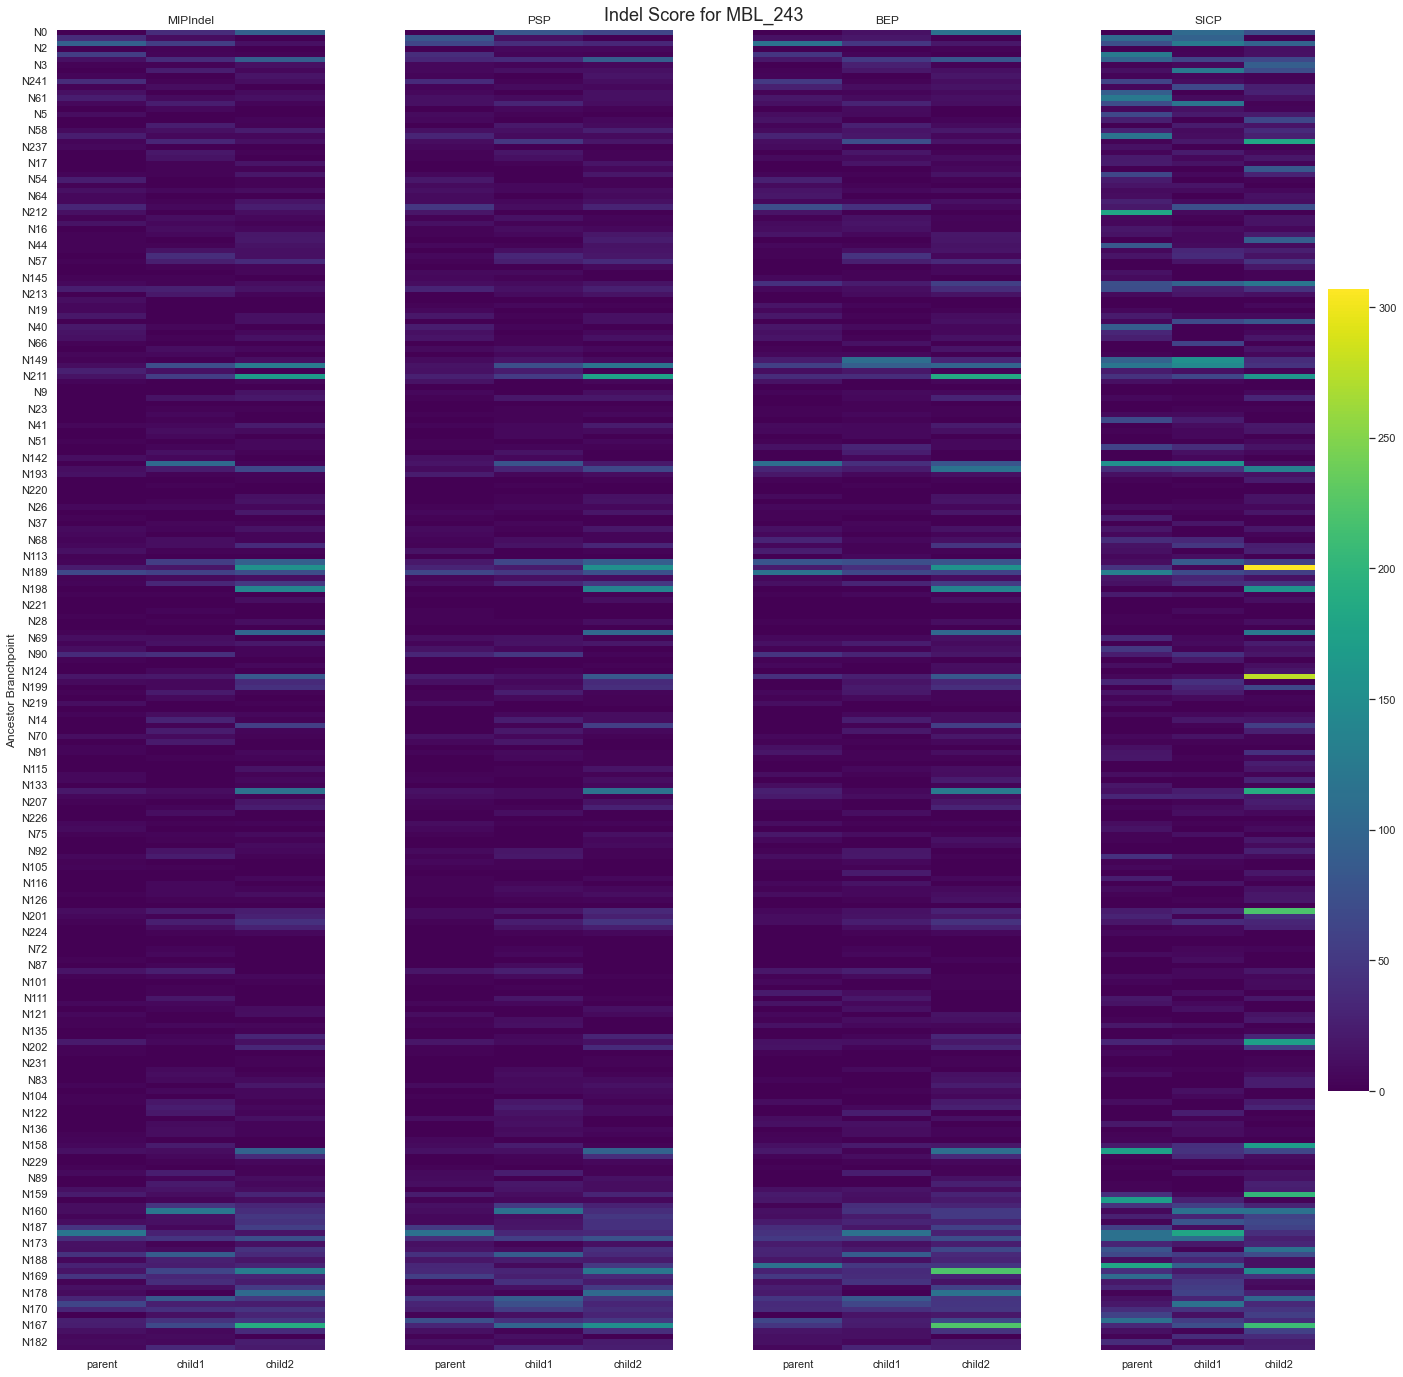

In [52]:
# min/max values
vmax_val = max(g_max,m_max,s_max,p_max)

sns.set(rc = {'figure.figsize':(20,20)})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.tight_layout(pad=4.0)

sns.heatmap(m_tree_indel_score_df, cmap='viridis',vmin=0, vmax=vmax_val,fmt="d",linewidths=0,xticklabels = True,\
            ax=ax1,cbar=False)
ax1.title.set_text('MIPIndel')

sns.heatmap(p_tree_indel_score_df, cmap='viridis',vmin=0, vmax=vmax_val,fmt="d",linewidths=0,xticklabels = True,\
            ax=ax2,cbar=False,yticklabels=False)
ax2.title.set_text('PSP')

sns.heatmap(g_tree_indel_score_df, cmap='viridis',vmin=0, vmax=vmax_val,fmt="d",xticklabels = True,\
            linewidths=0,ax=ax3,cbar=False,yticklabels=False)
ax3.title.set_text('BEP')

sns.heatmap(s_tree_indel_score_df, cmap='viridis',vmin=0, vmax=vmax_val,fmt="d",xticklabels = True,\
            linewidths=0,ax=ax4,yticklabels=False)
ax4.title.set_text('SICP')


fig.suptitle(f' Indel Score for {tree_name} ', fontsize=18)
ax1.set_ylabel('Ancestor Branchpoint')
plt.show()